## Coursework Task 1: Extracting Entities from Scientific Abstracts

In Natural Language Processing, Named Entity Recognition is a process of extracting the important information from large unstructered text data and classifying those entities into suitable categories. In this project, we will look at the task of extracting entity types such as Task, Process and Material from corpus of text.

**WARNING:** If you are interested in running this notebook, please install keras 1.14.0 and tensorflow 2.3.1. There are some dependency issues with the latest tensorflow library.

**Reference** : https://towardsdatascience.com/named-entity-recognition-ner-meeting-industrys-requirement-by-applying-state-of-the-art-deep-698d2b3b4ede

## Method 2: BiLSTM with ELMo embeddings

In [4]:
import os
from scienceie_loader import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import Counter

import keras
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import backend as K
import tensorflow as tf
import tensorflow_hub as hub

import warnings
warnings.filterwarnings("always")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
#version of tensorflow and keras
print(f"The versions of tensorflow and keras are {tf.__version__} and {keras.__version__}.")

The versions of tensorflow and keras are 1.14.0 and 2.3.1.


In [5]:
#import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.disable_v2_behavior()

In [6]:
#path for dataset
data_root = os.path.join(os.getcwd(), 'original_datasets')
data_train = os.path.join(data_root, 'scienceie2017_train/train2')
data_dev = os.path.join(data_root, 'scienceie2017_dev/dev')
data_test = os.path.join(data_root, 'semeval_articles_test')

In [ ]:
#tokenize and assigning NER tags
train_docs, train_rels, _ = load_tokenized_data(data_train)
dev_docs, dev_rels, _ = load_tokenized_data(data_dev)
test_docs, test_rels, _ = load_tokenized_data(data_test)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [8]:
#splitting document into sentences

def doc_to_sentence(docs):
    result = []
    temp = []
    atemp = []
    
    for doc in docs:
        for word, tag in doc:
            if word != ".":
                atemp.append((word, tag))
            else:
                atemp.append(('.', 'O'))
                temp.append(atemp)
                atemp = list()
                
        result.append(temp)
        temp = list()
            
    return result

In [9]:
train = list(itertools.chain.from_iterable(doc_to_sentence(train_docs)))
dev = list(itertools.chain.from_iterable(doc_to_sentence(dev_docs)))
test = list(itertools.chain.from_iterable(doc_to_sentence(test_docs)))
data = train+test 

In [10]:
tagss = [tag for sent in train for sent, tag in sent]
tagss_count = Counter(tagss)
tagss_count

Counter({'B-Task': 1086,
         'I-Task': 4266,
         'O': 43767,
         'B-Process': 2727,
         'I-Process': 5666,
         'B-Material': 2251,
         'I-Material': 2558})

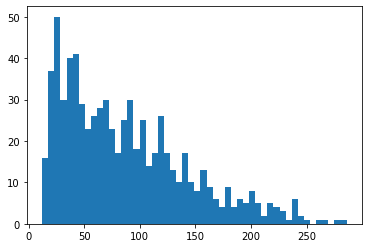

In [11]:
plt.hist([len(sen) for sen in train], bins= 50)
plt.show()

The histogram tells us that most of the sentences with the length in the range between 20 to 200. So, we will consider 150 as maximum length.

### Vocabulary is made of all the words in train and test sets.

In [12]:
#vocabulary
words = list({word for sentence in data for word, tag in sentence})
words_length = len(words)
print(words_length)

12241


In [13]:
#Possible ner tags
tags = list({tag for doc in train_docs for word, tag in doc})
tags_length = len(tags)
print(tags_length)

7


In [14]:
#maximum length of a sentence to consider
max_len = 150
tags2index = {t:i for i,t in enumerate(tags)}
idx2tag = {i: w for w, i in tags2index.items()}

In [15]:
tagss_count

Counter({'B-Task': 1086,
         'I-Task': 4266,
         'O': 43767,
         'B-Process': 2727,
         'I-Process': 5666,
         'B-Material': 2251,
         'I-Material': 2558})

In [16]:
def padding(lst):
    """function that assign the term 'Padding' if the sentence is less than max_len"""
    result = []
    for sentence in lst:
        temp = []
        for i in range(max_len):
            try:
                temp.append(sentence[i][0])
            except:
                temp.append("Padding")
        result.append(temp)
        
    return result
X_tr = padding(train)
X_dev = padding(dev)
X_te = padding(test)

In [17]:
def pad_seq(lst):
    """function that create a sequence of padding (converting tags to index)"""
    result = []
    for sentence in lst:
        temp = []
        for tup in sentence:
            temp.append(tags2index[tup[1]])
            
        result.append(temp)
        
    return result
  
y_tr = pad_sequences(maxlen = max_len, sequences = pad_seq(train), padding = "post", value = tags2index["O"])
y_te = pad_sequences(maxlen = max_len, sequences = pad_seq(test), padding = "post", value = tags2index["O"])
y_dev = pad_sequences(maxlen = max_len, sequences = pad_seq(dev), padding = "post", value = tags2index["O"])

It takes sometime to install elmo embedding if you are installing for the first time.

Initialize the ELMo embedding from tensorflow hub

In [18]:
sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True) #ELMO embedding files
sess.run(tf.compat.v1.global_variables_initializer())
sess.run(tf.tables_initializer())

In [19]:
batch_size = 32
def ElmoEmbedding(x):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(x,tf.string)),"sequence_len": tf.constant(batch_size*[max_len])
                     },
                      signature="tokens",
                      as_dict=True)["elmo"]

1024 dimensional vectors of the ELMo embeddings.

In [ ]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)

x = add([x, x_rnn])
output = TimeDistributed(Dense(tags_length, activation="softmax"))(x)


In [21]:
model = Model(input_text, output)
model.compile(optimizer="adam", loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

E:\Anaconda\envs\deepta\lib\site-packages\tensorflow\python\framework\tensor_util.py:538: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
E:\Anaconda\envs\deepta\lib\site-packages\tensorflow\python\framework\tensor_util.py:538: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
E:\Anaconda\envs\deepta\lib\site-packages\tensorflow\python\framework\tensor_util.py:538: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


The number of samples divisible by the batch_size.

In [22]:
X_train = X_tr[:22*batch_size]
X_val = X_dev[:3*batch_size]
y_train = y_tr[:22*batch_size]
y_val = y_dev[:3*batch_size]
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [ ]:
history = model.fit(np.array(X_train), y_train, validation_data=(np.array(X_val), y_val),batch_size=batch_size, epochs=3, verbose=1)

In [24]:
X_test = X_te[:7*batch_size]
test_pred = model.predict(np.array(X_test), verbose=1)

224/224 [==============================] - 50s 222ms/step


In [25]:
def pred2label(pred):
    """function to convert tags2idx to label in predicted list"""
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
     """function to convert tags2idx to label in test list"""
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:7*batch_size])

In [26]:
#predicted and true labels
pred = list(itertools.chain.from_iterable(pred_labels))
true = list(itertools.chain.from_iterable(test_labels))

In [27]:
#words list length
n_words = len(words)

In [29]:
labels = [tag for word, tag in list(idx2tag.items())]

In [30]:
print(classification_report(true, pred, target_names=labels))

              precision    recall  f1-score   support

   B-Process       0.42      0.22      0.29       670
   I-Process       0.33      0.07      0.11       712
  B-Material       0.00      0.00      0.00       131
      I-Task       0.47      0.18      0.26       650
      B-Task       0.38      0.11      0.17      1012
           O       0.25      0.13      0.17       550
  I-Material       0.91      0.99      0.95     29875

    accuracy                           0.89     33600
   macro avg       0.39      0.24      0.28     33600
weighted avg       0.85      0.89      0.86     33600



E:\Anaconda\envs\deepta\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\envs\deepta\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\envs\deepta\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
def BPT(lst):
    
    """function that converts B and I tags of a given entity to single
    NER tag"""
    
    #example: "B-Process" and "I-Process" to "Process"

    result = []
    
    for element in lst:
        if element == "O":
            result.append("O")
        elif element == "B-Material" or element == "I-Material":
            result.append("Material")
        elif element == "B-Process" or element == "I-Process":
            result.append("Process")
        elif element == "B-Task" or element == "I-Task":
            result.append("Task")
            
    return result 

In [32]:
print(classification_report(BPT(true), BPT(pred)))

              precision    recall  f1-score   support

    Material       0.54      0.25      0.34      1320
           O       0.91      0.99      0.95     29875
     Process       0.42      0.11      0.17      1724
        Task       0.27      0.11      0.16       681

    accuracy                           0.89     33600
   macro avg       0.53      0.36      0.40     33600
weighted avg       0.86      0.89      0.87     33600



## Error analysis

In [58]:
#store the values of entity, true and pred
dictionary = {
             "true tag":[],
             "predicted tag":[]}

In [65]:
dictionary["entity"] = [word for word, tag in test[82][:11]]
dictionary["true tag"] = test_labels[82][:11]
dictionary["predicted tag"] = pred_labels[82][:11]

In [66]:
#dataframe
df = pd.DataFrame(data = dictionary)
df = df[["entity", "true tag", "predicted tag"]]
df

,entity,true tag,predicted tag
0,Apache,B-Process,B-Process
1,Pig,I-Process,O
2,is,O,O
3,a,O,O
4,platform,O,O
5,for,O,O
6,creating,O,O
7,MapReduce,B-Process,I-Task
8,workflows,I-Process,I-Task
9,with,O,O
